In [34]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [35]:
import pandas as pd
import technical_analysis.backtest_kz as bt
from data_pipelines.data_manipulation import DataManipulation
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

In [36]:
SYMBOL = 'BTC-USD'
scale = 1
range_list = [5, 10, 15, 20, 25, 30, 50, 99]
range_list = [i*scale for i in range_list]
period = '2y'
interval = '1h'
start_date = ''
end_data = ''
source = 'yahoo'

In [37]:
data = DataManipulation(SYMBOL, source, range_list, period=period, interval=interval, scale=scale, prefix_path='..')

In [38]:
features_labels = data.extract_features()

In [39]:
features_labels.shape

(16689, 115)

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [41]:
features_labels = features_labels.replace([np.inf, -np.inf], np.nan).dropna()
features_labels.describe()
features_labels.to_csv('./features_labels.csv')

In [42]:
X_train = features_labels[:'2022-08-01']
X_test = features_labels['2022-08-01':]

In [43]:
X_train.shape, X_test.shape

((7243, 115), (1183, 115))

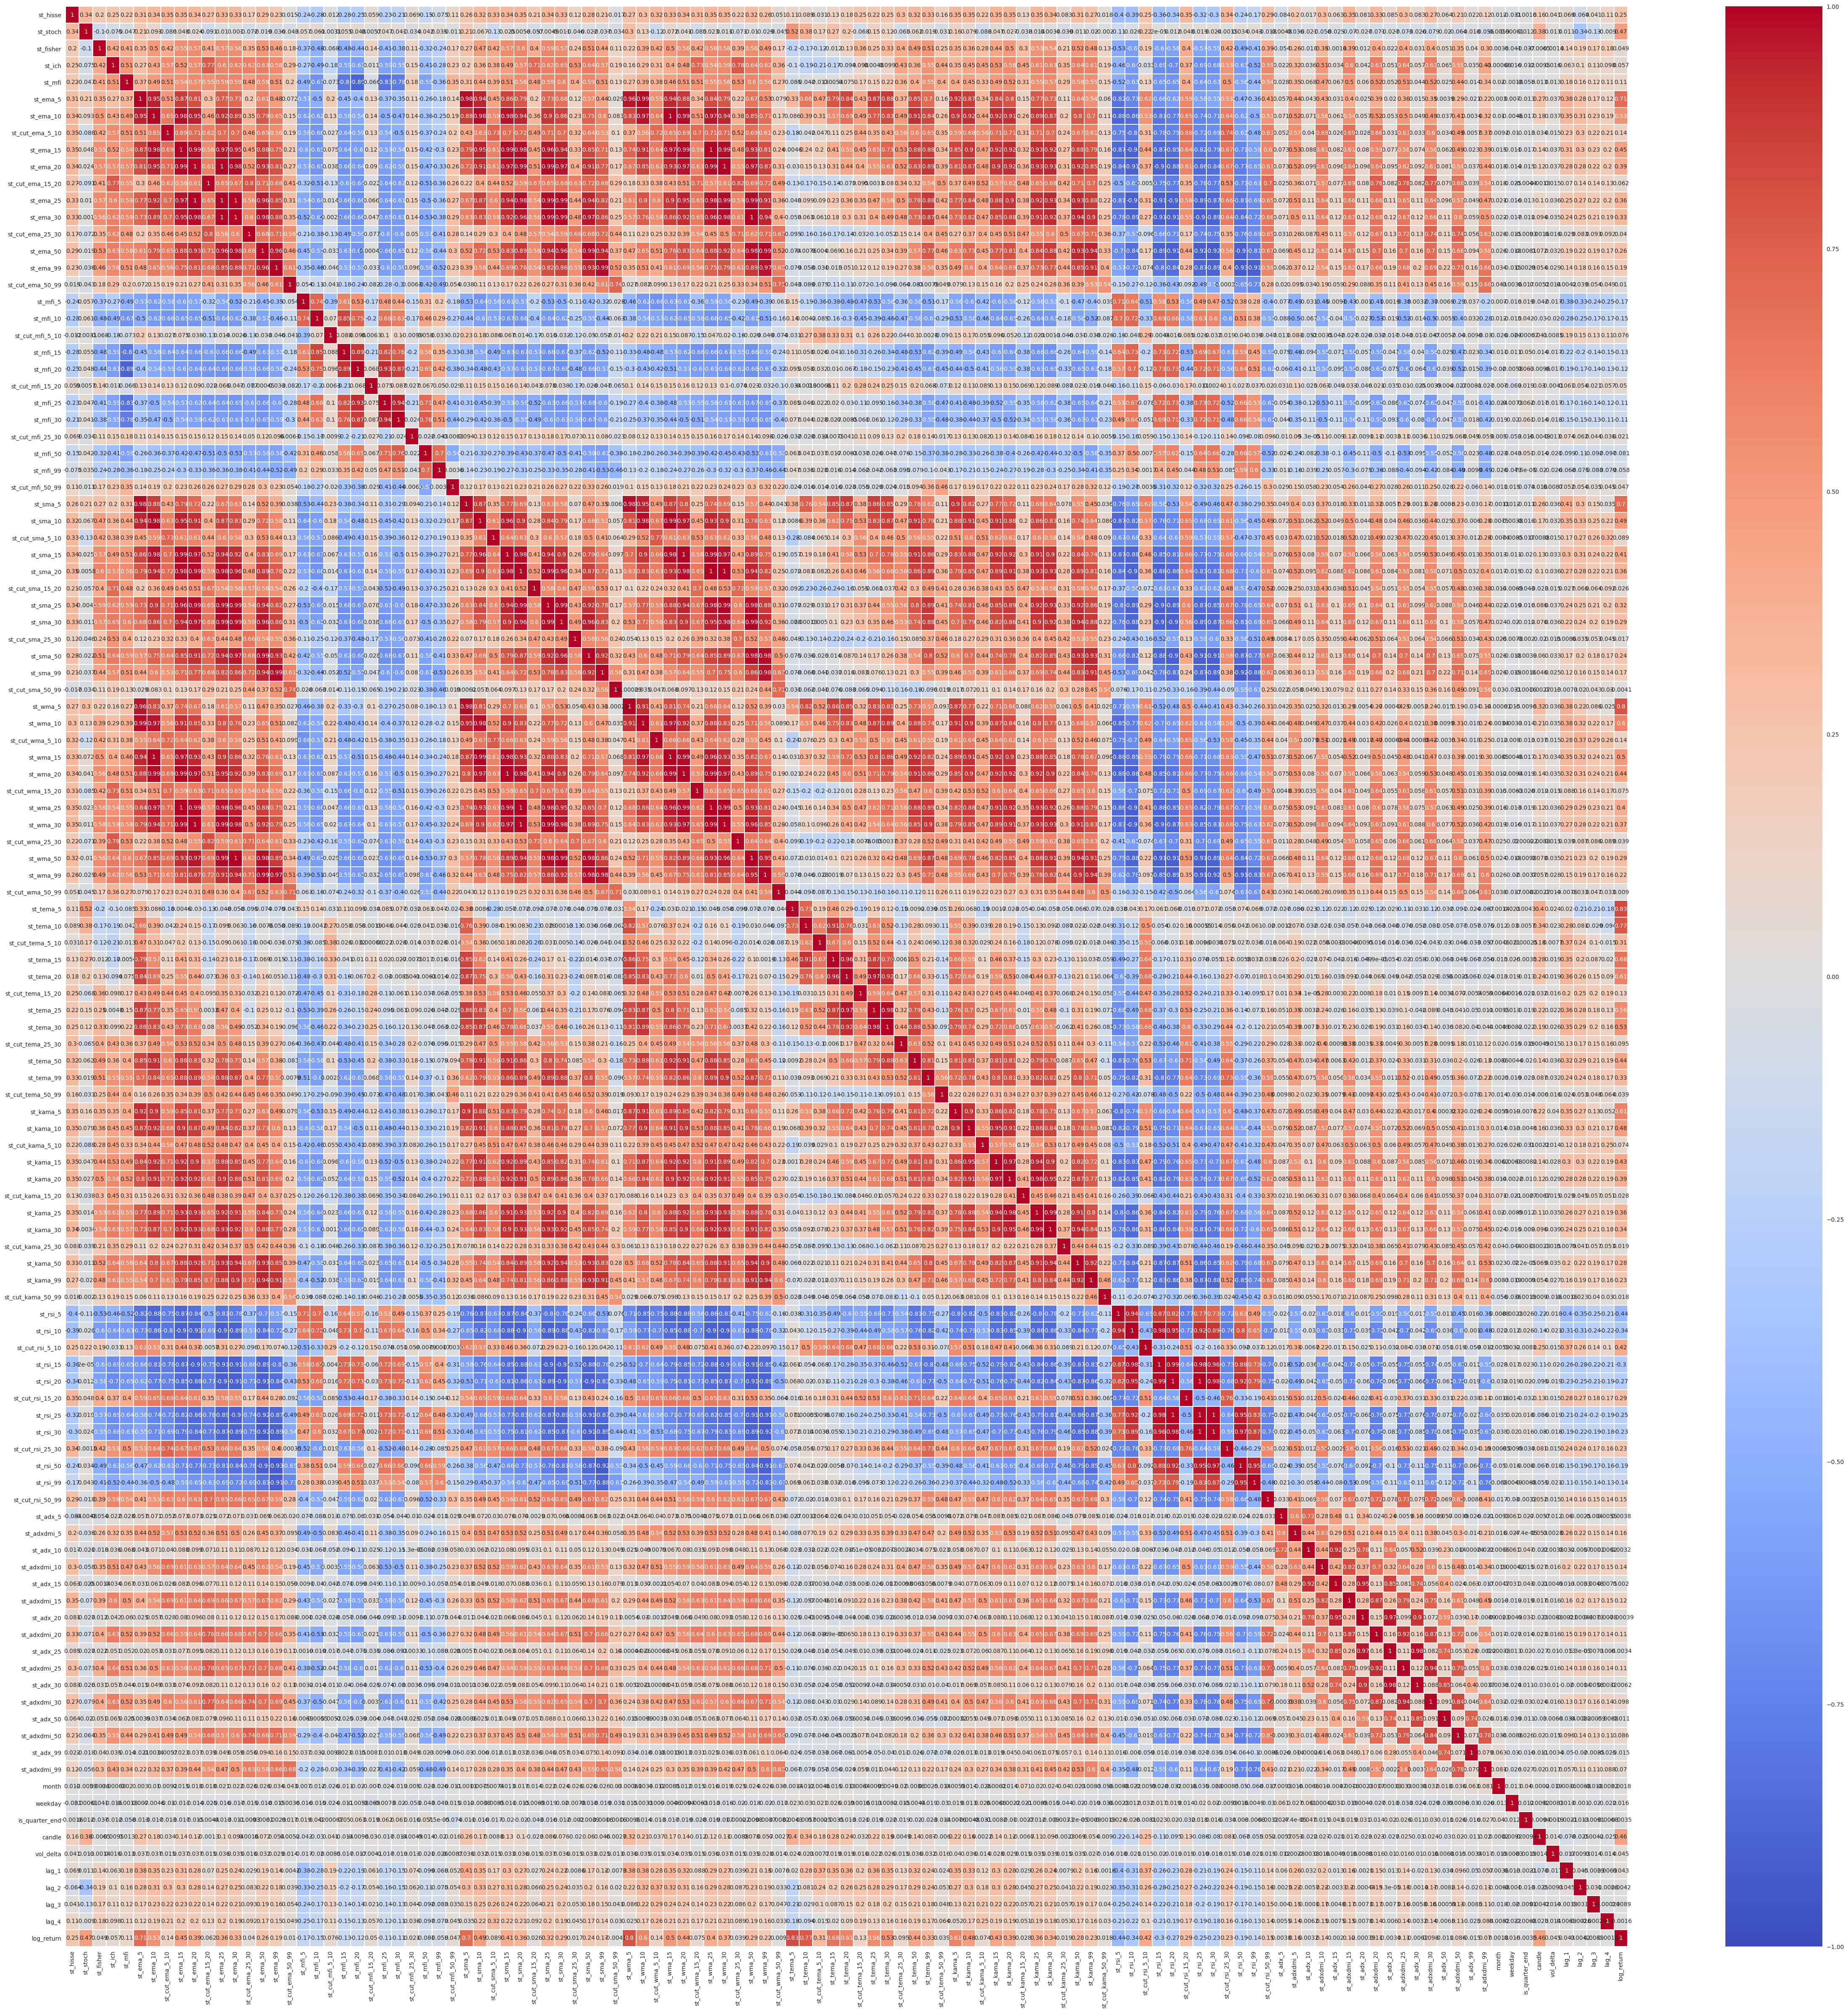

In [44]:
plt.figure(figsize=(60,60))
sns.heatmap(X_train.corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

In [45]:
correlation_matrix = X_train.corr()

In [46]:
correlation_matrix['log_return'].sort_values().tail(20)

st_wma_20    0.4414
st_ema_15    0.4475
candle       0.4640
st_stoch     0.4739
st_kama_10   0.4841
st_sma_10    0.4912
st_wma_15    0.5007
st_tema_30   0.5280
st_ema_10    0.5333
st_tema_25   0.5638
st_wma_10    0.5986
st_kama_5    0.6052
st_tema_20   0.6116
st_tema_15   0.6784
st_sma_5     0.6965
st_ema_5     0.7064
st_tema_10   0.7687
st_wma_5     0.8008
st_tema_5    0.8288
log_return   1.0000
Name: log_return, dtype: float64

In [47]:
X_tr = X_train.drop("log_return", axis=1)
y_tr = X_train["log_return"]   

In [48]:
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [49]:
X_t = X_test.drop("log_return", axis=1)
y_t = X_test["log_return"]

In [50]:
# A parameter grid for XGBoost
params = {
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}
# Initialize XGB and GridSearch
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')
grid = GridSearchCV(xgb_reg, params)
grid.fit(X_tr, y_tr)
gridcv_xgb = grid.best_estimator_
print(r2_score(y_t, gridcv_xgb.predict(X_t)))

-0.0022690011014492306


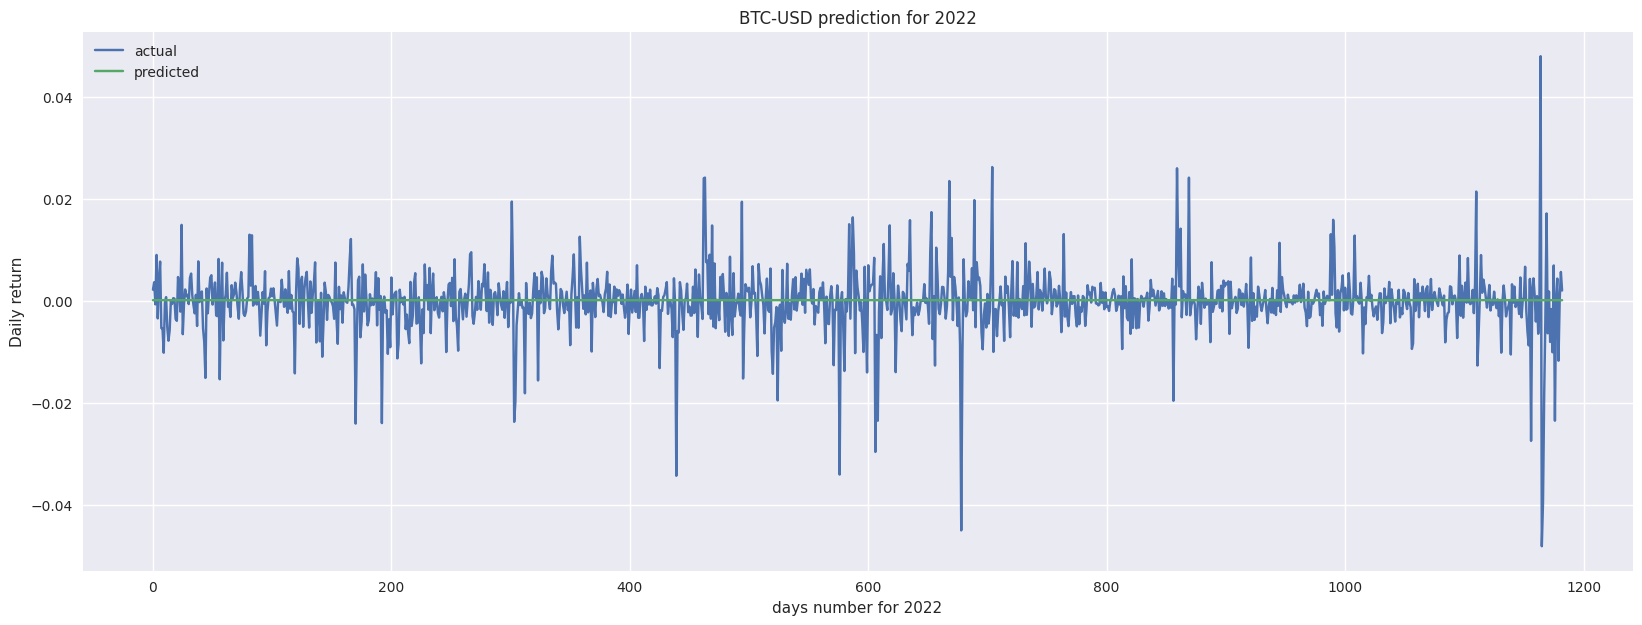

In [51]:
y_t = y_t.reset_index()
y_pred = gridcv_xgb.predict(X_t)
y_pred = pd.DataFrame(y_pred)
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(y_t.log_return, label='actual')
ax.plot(y_pred, label='predicted')
ax.set_ylabel('Daily return')
ax.set_xlabel('days number for 2022')
ax.set_title(f'{SYMBOL} prediction for 2022')
ax.legend()